# Building Smoke Estimates from the fire data, and a comparison with the AQI Data


We have both the wildfire data history for area surrounding the Grand Junction City and the Data from All the AQI data. Let us now use these to compare and build our smoke estimate model.

In [62]:
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [8]:
with open('../data/Grand_Junction_Wildfire_Features_geometry_dropped.json') as f:
    my_features = json.load(f)

In [246]:
#Checking if the features have loaded properly
len(my_features)

94768

### Step 1: Building a smoke estimate using the Area burned and the distance from city

We only have 2 features that we can use to calculate the impact. These are area burned and distance. The initial estimate could be of the following:

Smoke Estimate *(Proportional to)* Area_Burned / (Distance from fire ^ 3 )



In [335]:
# Finding the average smoke created each year.
total_smoke = {}
count_per_year = {}

for fire in my_features:
    year = fire['attributes']['Fire_Year']
    area = fire['attributes']['GIS_Hectares']
    distance = fire['attributes']['distance_from_city']
    smoke_created = 1.2* (1- distance/1250)*(150-area/150) 
    #smoke_created = np.abs(np.log(area/distance))
    
    if year in total_smoke:
        total_smoke[year] += smoke_created
        count_per_year[year] += 1
    else:
        total_smoke[year] = smoke_created
        count_per_year[year] = 1

# Calculate the average smoke created for each year
average_smoke = {year: total_smoke[year] / count_per_year[year] for year in total_smoke}

In [336]:
average_smoke_area_distance_estimate = pd.DataFrame(list(average_smoke.items()), columns=['Year', 'Smoke Estimate'])
average_smoke_area_distance_estimate.to_csv('../data/average_smoke_area_distance_estimate.csv', index = False)

In [337]:
average_smoke_area_distance_estimate

,Year,Smoke Estimate
0,1963,98.351730
1,1964,91.659925
2,1965,89.829753
3,1966,94.581469
4,1967,88.885973
5,1968,85.463491
6,1969,89.979721
7,1970,82.736205
8,1971,93.909693
9,1972,90.974271


### Step 2: Building an AQI estimate from the daily data

In [338]:
# importing the daily data for gaseous and particulate data
particulate_data = pd.read_csv('../data/Daily_particulate_data_Grand_Junction.csv')
gas_data= pd.read_csv('../data/Daily_gas_data_Grand_Junction.csv')

In [339]:
combined = pd.concat([gas_data,particulate_data])

In [340]:
# Group by 'Date' and find the maximum 'Avg AQI' for each date
result_df = combined.groupby('Date')['Avg AQI'].max().reset_index()

# Rename the 'Avg AQI' column to 'Max Avg AQI'
result_df = result_df.rename(columns={'Avg AQI': 'Max AQI'})

In [341]:
# Convert the 'Date' column to datetime format
result_df['Date'] = pd.to_datetime(result_df['Date'], format='%Y%m%d')

# Extract the year from the 'Date' column
result_df['Year'] = result_df['Date'].dt.year

# Sort the DataFrame by 'Year' and 'Max Avg AQI' in descending order
result_df = result_df.sort_values(by=['Year', 'Max AQI'], ascending=[True, False])

# Group by 'Year' and select the top 5 AQI readings for each year
top_5_aqi = result_df.groupby('Year').head(5)

# Group by 'Year' and calculate the average of the top 5 AQI readings
average_top_5_aqi = top_5_aqi.groupby('Year')['Max AQI'].mean().reset_index()

In [348]:
average_top_5_aqi.to_csv('../data/average_top_5_aqi.csv', index = False)

In [349]:
average_top_5_aqi

,Year,Max AQI
0,1976,39.600000
1,1977,87.200000
2,1978,95.200000
3,1979,43.800000
4,1980,63.400000
5,1981,85.600000
6,1982,74.800000
7,1983,136.800000
8,1984,66.000000
9,1985,64.800000


In [350]:
average_smoke_area_distance_estimate

,Year,Smoke Estimate
0,1963,98.351730
1,1964,91.659925
2,1965,89.829753
3,1966,94.581469
4,1967,88.885973
5,1968,85.463491
6,1969,89.979721
7,1970,82.736205
8,1971,93.909693
9,1972,90.974271


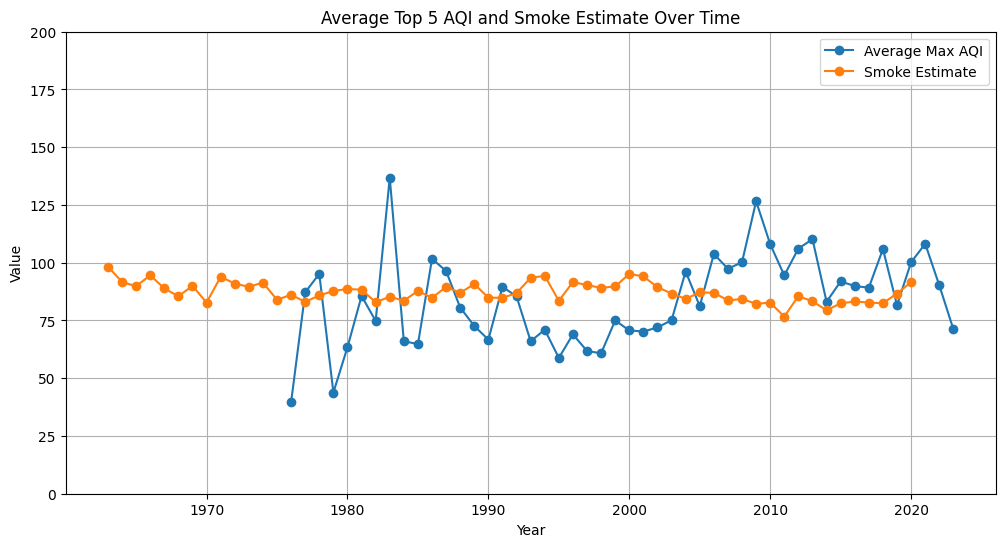

In [312]:
# Convert 'Year' column to datetime format with a year-only format
average_top_5_aqi['Year'] = pd.to_datetime(average_top_5_aqi['Year'], format='%Y')

average_smoke_area_distance_estimate['Year'] = pd.to_datetime(average_smoke_area_distance_estimate['Year'], format='%Y')

# Set 'Year' as the index
average_top_5_aqi.set_index('Year', inplace=True)

# Set 'Year' as the index for the second DataFrame
average_smoke_area_distance_estimate.set_index('Year', inplace=True)

# Create a figure for both plots
plt.figure(figsize=(12, 6))

# Plot the first graph
plt.plot(average_top_5_aqi.index, average_top_5_aqi['Max AQI'], marker='o', linestyle='-', label='Average Max AQI')

# Plot the second graph on the same plot
plt.plot(average_smoke_area_distance_estimate.index, average_smoke_area_distance_estimate['Smoke Estimate'], marker='o', linestyle='-', label='Smoke Estimate')

# Set titles and labels
plt.title('Average Top 5 AQI and Smoke Estimate Over Time')
plt.xlabel('Year')
plt.ylabel('Value')

# Display legend
plt.legend()
plt.ylim(0, 200)

# Display the plot
plt.grid(True)
plt.show()

## Time series Prediction.

Let us create a basec Arima Model to extrapolate the results and see what the next 25 years would look like

In [326]:
# Load your data
data = pd.Series(average_smoke_area_distance_estimate['Smoke Estimate'])  

model = auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True,
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

# Get the best order (p, d, q) determined by auto_arima
best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)

# Fit ARIMA model
model = ARIMA(data, order=(4, 2, 2))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=29)
predictions_data = pd.DataFrame({'Year': range(2021, 2050), 'Smoke Estimate': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=336.628, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=329.806, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=324.732, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=332.628, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=328.734, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=328.735, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=321.107, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=325.136, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=325.136, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=325.853, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=inf, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.774 seconds
Best (p, d, q) order: (0, 1, 1)


C:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\aadit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

AIC : 327.2162611411835 BIC : 341.39372297632957


In [327]:
predictions_data.drop(columns = ['Year'], inplace = True)
predictions_data.to_csv('../data/predictions_data.csv')

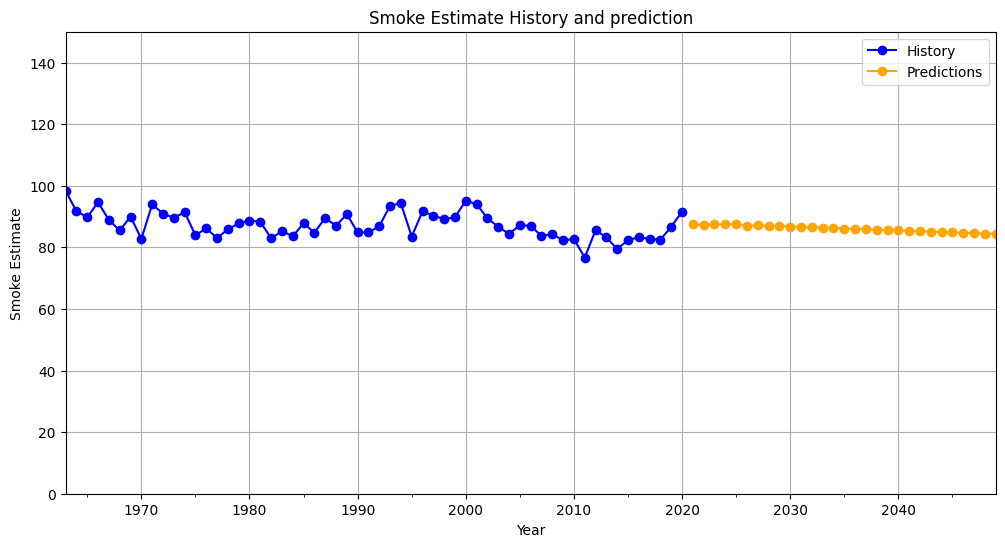

In [328]:
# Plot the history with grid and y-axis limit


average_smoke_area_distance_estimate['Smoke Estimate'].plot(label='History', color='blue', marker='o', markersize=6, figsize=(12, 6), ylim=(0, 150))

# Plot the predictions on the same figure
predictions_data['Smoke Estimate'].plot(label='Predictions', color='orange', marker='o', markersize=6 , grid=True)

# Set labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate History and prediction')
plt.legend()

# Show the plot
plt.show()

In [329]:
average_smoke_area_distance_estimate

,Smoke Estimate
Year,
1963-01-01,98.351730
1964-01-01,91.659925
1965-01-01,89.829753
1966-01-01,94.581469
1967-01-01,88.885973
1968-01-01,85.463491
1969-01-01,89.979721
1970-01-01,82.736205
1971-01-01,93.909693


### Scratchpad
 You can ignore the code here, this might be useful in future development

In [ ]:
# # Convert 'Year' column to datetime format with a year-only format
# average_top_5_aqi['Year'] = pd.to_datetime(average_top_5_aqi['Year'], format='%Y')

# average_top_5_aqi.set_index('Year', inplace=True)

# # Set 'Year' as the index for the second DataFrame
# average_smoke_area_distance_estimate.set_index('Year', inplace=True)

# # Create a figure for both plots
# plt.figure(figsize=(12, 6))

# # Plot the first graph
# plt.plot(average_top_5_aqi.index, average_top_5_aqi['Max AQI'], marker='o', linestyle='-', label='Average Max AQI')

# # Plot the second graph on the same plot
# plt.plot(average_smoke_area_distance_estimate.index, average_smoke_area_distance_estimate['Smoke Estimate'], marker='o', linestyle='-', label='Smoke Estimate')

# # Set titles and labels
# plt.title('Average Top 5 AQI and Smoke Estimate Over Time')
# plt.xlabel('Year')
# plt.ylabel('Value')

# # Display legend
# plt.legend()

# # Display the plot
# plt.grid(True)
# plt.show()

In [ ]:
## Scratchpad
# # Total Area burned time series
# total_area = {}
# for fire in my_features:
#     year = fire['attributes']['Fire_Year']
#     area = fire['attributes']['GIS_Acres']
    
#     if year in total_area:
#         total_area[year]+=area
#     else:
#         total_area[year]=area

# years = list(total_area.keys())
# values = list(total_area.values())

# plt.figure(figsize=(12, 6))
# plt.plot(years, values, marker='o', linestyle='-')
# plt.title('Time Series Plot')
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.grid(True)
# plt.show()



# # Total Distance per year - makes no sense, but just looking at this
# total_distance = {}
# for fire in my_features:
#     year = fire['attributes']['Fire_Year']
#     distance = fire['attributes']['distance_from_city']
#     if year in total_distance:
#         total_distance[year]+=distance
#     else:
#         total_distance[year]=distance
        
        
# years = list(total_distance.keys())
# values = list(total_distance.values())

# plt.figure(figsize=(12, 6))
# plt.plot(years, values, marker='o', linestyle='-')
# plt.title('Time Series Plot')
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.grid(True)
# plt.show()


## Fires Grouped by Year
# fires_grouped_by_year = {}
# for fire in my_features:
#     year = str(fire["attributes"]["Fire_Year"])
#     if(year not in fires_grouped_by_year.keys()):
#         fires_grouped_by_year[year] = []
#         fires_grouped_by_year[year].append(fire)
#     else:
#         fires_grouped_by_year[year].append(fire)

In [ ]:
# # Convert the 'Year' column to a datetime format with a year-only format
# average_top_5_aqi['Year'] = pd.to_datetime(average_top_5_aqi['Year'], format='%Y')

# # Set the 'Year' column as the index
# average_top_5_aqi.set_index('Year', inplace=True)

# # Create a time series plot
# plt.figure(figsize=(12, 6))
# plt.plot(average_top_5_aqi.index, average_top_5_aqi['Max AQI'], marker='o', linestyle='-')
# plt.title('Average of Top 5 AQI Readings by Year')
# plt.xlabel('Year')
# plt.ylabel('Average Max AQI')
# plt.grid(True)

# # Display the plot
# plt.show()

In [ ]:
# # Convert 'Year' column to datetime type
# #average_smoke_area_distance_estimate['Year'] = pd.to_datetime(average_smoke_area_distance_estimate['Year'])

# # Set 'Year' as the index
# average_smoke_area_distance_estimate.set_index('Year', inplace=True)

# # Plot the time series
# plt.figure(figsize=(10, 6))
# plt.plot(average_smoke_area_distance_estimate['Smoke Estimate'], marker='o', linestyle='-')
# plt.title('Smoke Estimate Over Time')
# plt.xlabel('Year')
# plt.ylabel('Smoke Estimate')
# plt.grid(True)
# plt.show()

In [ ]:
## Total Smoke with formula, not the average -> Probably not a good idea, hence not use further

# total_smoke = {}
# for fire in my_features:
#     year = fire['attributes']['Fire_Year']
#     area = fire['attributes']['GIS_Acres']
#     distance = fire['attributes']['distance_from_city']
#     smoke_created = area /(distance **3)
    
#     if year in total_smoke:
#         total_smoke[year]+=smoke_created
#     else:
#         total_smoke[year]=smoke_created